In [13]:
# Razvan Olariu - 411 - Lab 4 - Anomaly detection
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyod.utils.data import generate_data
from pyod.models.ocsvm import OCSVM
from pyod.models.deep_svdd import DeepSVDD
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


--- OCSVM Linear ---
Balanced Accuracy: 0.9833
ROC AUC: 1.0000


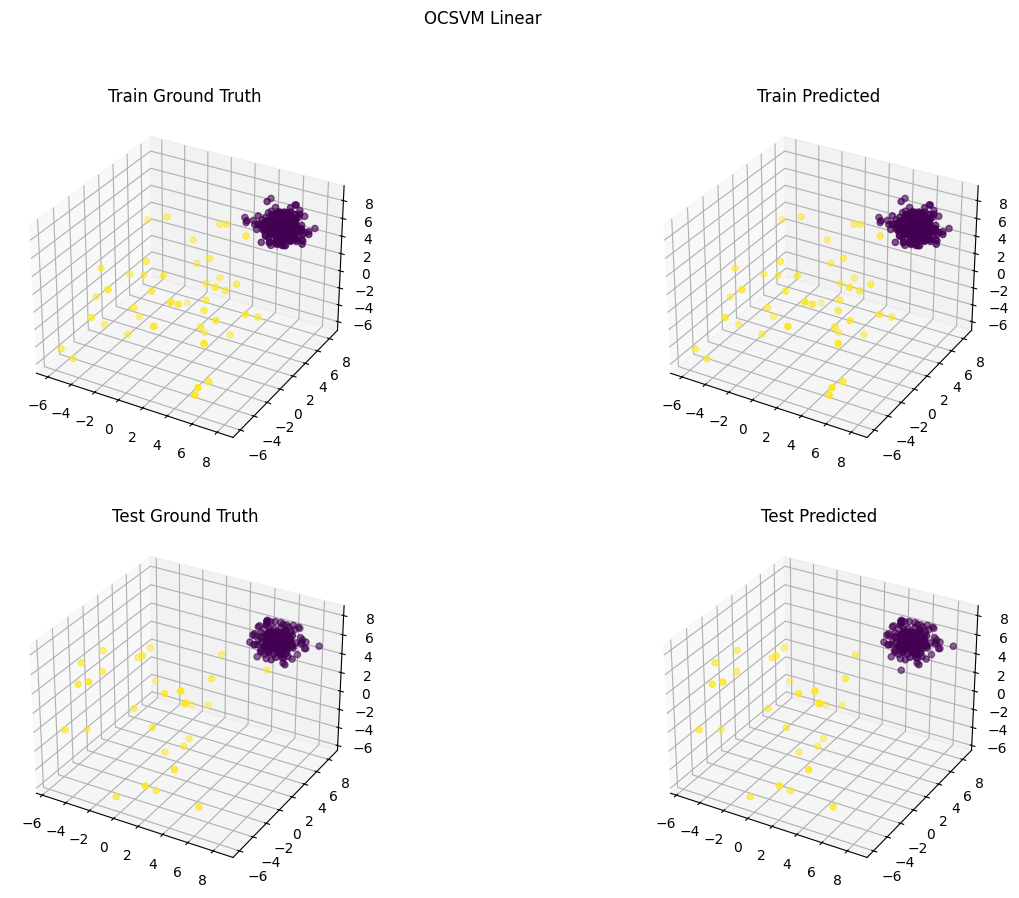


--- OCSVM RBF ---
Balanced Accuracy: 0.9804
ROC AUC: 0.9998


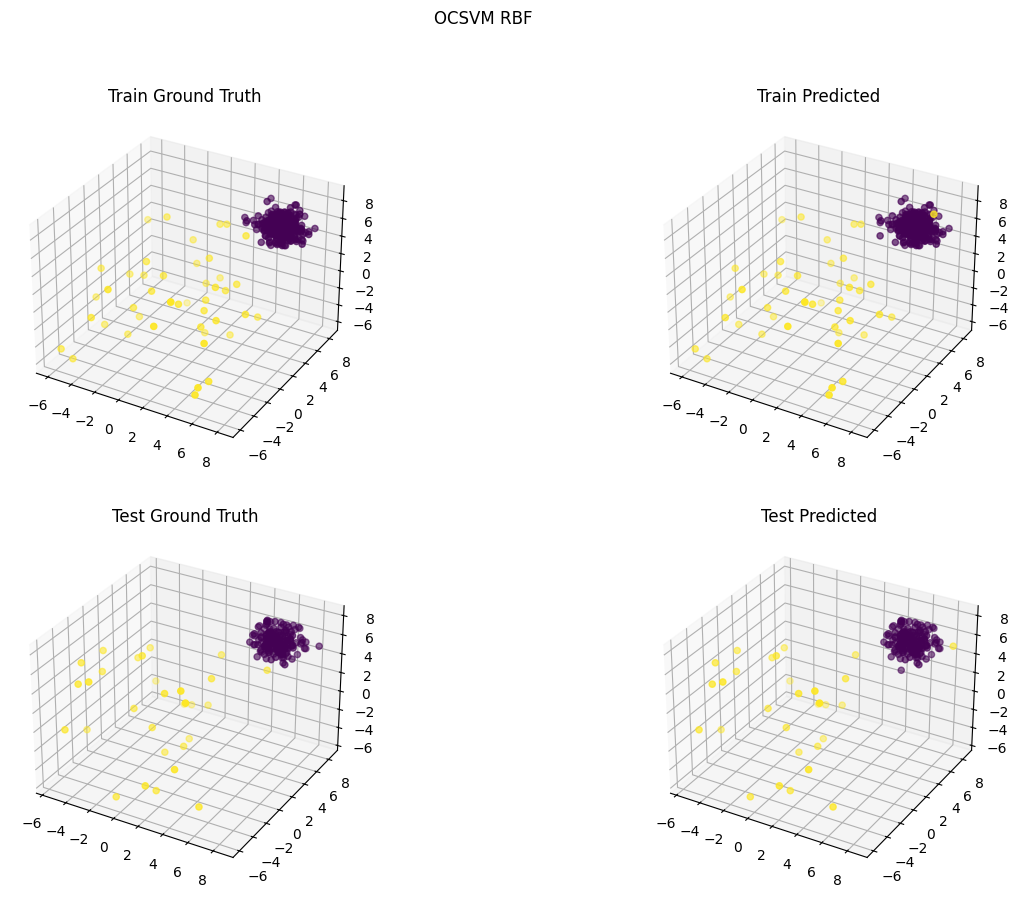


--- DeepSVDD ---
Epoch 1/20, Loss: 6.966450810432434
Epoch 2/20, Loss: 6.6218341588974
Epoch 3/20, Loss: 6.711485534906387
Epoch 4/20, Loss: 6.453721731901169
Epoch 5/20, Loss: 6.210710942745209
Epoch 6/20, Loss: 6.1917082369327545
Epoch 7/20, Loss: 6.477801620960236
Epoch 8/20, Loss: 6.637072786688805
Epoch 9/20, Loss: 6.536221280694008
Epoch 10/20, Loss: 6.4528917372226715
Epoch 11/20, Loss: 6.272726684808731
Epoch 12/20, Loss: 7.053814262151718
Epoch 13/20, Loss: 6.164215438067913
Epoch 14/20, Loss: 6.187401980161667
Epoch 15/20, Loss: 6.451780945062637
Epoch 16/20, Loss: 6.2170868664979935
Epoch 17/20, Loss: 6.32185897231102
Epoch 18/20, Loss: 6.434256047010422
Epoch 19/20, Loss: 6.7378900945186615
Epoch 20/20, Loss: 6.305033043026924
Balanced Accuracy: 0.9441
ROC AUC: 0.9753


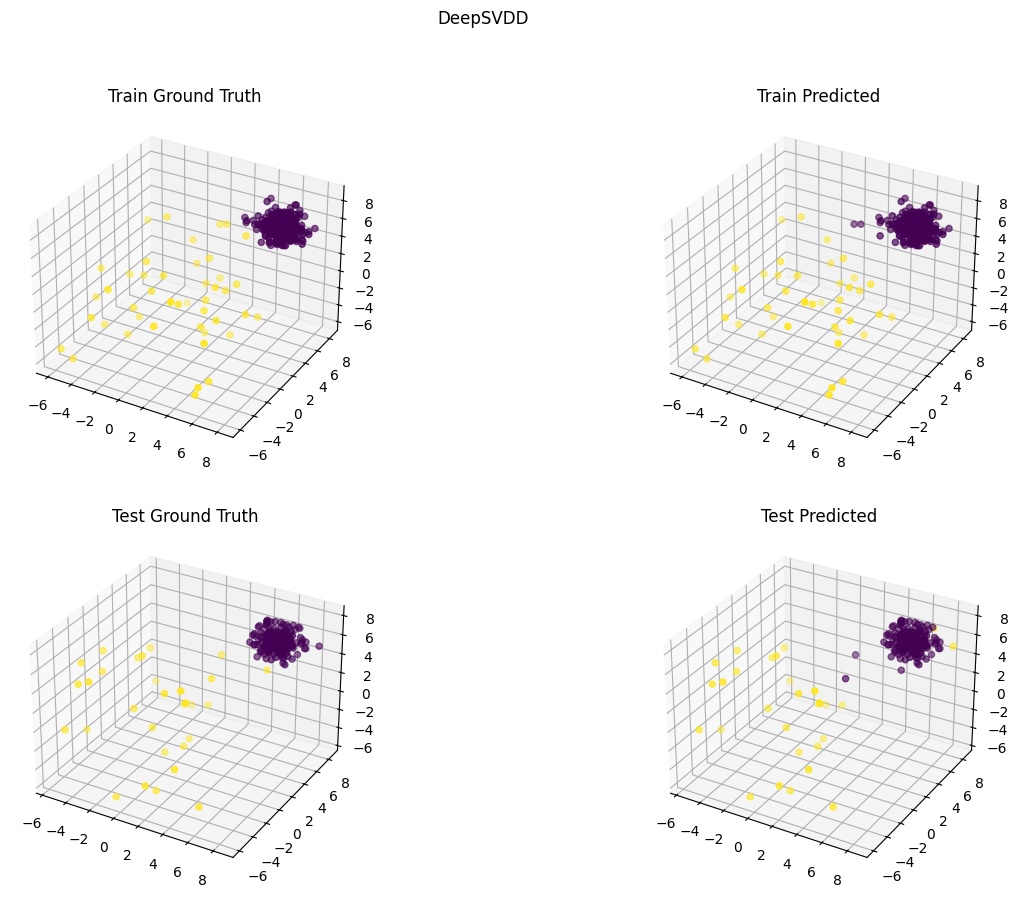

In [16]:
contamination = 0.15
n_train = 300
n_test = 200
n_features = 3

X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, n_test=n_test, n_features=n_features,
    contamination=contamination, random_state=42
)

def plot_4_subplots(X_train, y_train, y_train_pred, X_test, y_test, y_test_pred, title):
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(title)

    ax1 = fig.add_subplot(221, projection='3d')
    ax1.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train)
    ax1.set_title('Train Ground Truth')

    ax2 = fig.add_subplot(222, projection='3d')
    ax2.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train_pred)
    ax2.set_title('Train Predicted')

    ax3 = fig.add_subplot(223, projection='3d')
    ax3.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test)
    ax3.set_title('Test Ground Truth')

    ax4 = fig.add_subplot(224, projection='3d')
    ax4.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test_pred)
    ax4.set_title('Test Predicted')
    plt.show()

print("OCSVM Linear")
clf = OCSVM(kernel='linear', contamination=contamination)
clf.fit(X_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_test_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_scores):.4f}")
plot_4_subplots(X_train, y_train, y_train_pred, X_test, y_test, y_test_pred, "OCSVM Linear")

print("OCSVM RBF")
clf = OCSVM(kernel='rbf', contamination=contamination)
clf.fit(X_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_test_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_scores):.4f}")
plot_4_subplots(X_train, y_train, y_train_pred, X_test, y_test, y_test_pred, "OCSVM RBF")


print("DeepSVDD")
clf = DeepSVDD(contamination=contamination, random_state=42, epochs=20, verbose=0, n_features=n_features)
clf.fit(X_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_test_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_scores):.4f}")
plot_4_subplots(X_train, y_train, y_train_pred, X_test, y_test, y_test_pred, "DeepSVDD")

In [17]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, make_scorer


data = loadmat('cardio.mat')
X = data['X']
y = data['y'].ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4, random_state=42)

y_train_sklearn = np.where(y_train == 0, 1, -1)
y_test_sklearn = np.where(y_test == 0, 1, -1)

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ocsvm', OneClassSVM())
])

contamination = np.mean(y_train)

param_grid = {
    'ocsvm__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'ocsvm__gamma': ['scale', 'auto', 0.1, 0.01],
    'ocsvm__nu': [contamination, 0.05, 0.1, 0.2]
}

scorer = make_scorer(balanced_accuracy_score)

grid = GridSearchCV(pipeline, param_grid, scoring=scorer, cv=3, n_jobs=-1)
grid.fit(X_train, y_train_sklearn)

print("Best params:", grid.best_params_)

# Evaluate on test
best_model = grid.best_estimator_
y_pred_test = best_model.predict(X_test)

print(f"Balanced Accuracy on test: {balanced_accuracy_score(y_test_sklearn, y_pred_test):.4f}")

--- Exercise 2 ---
Contamination in train: 0.0984
Best params: {'ocsvm__gamma': 0.01, 'ocsvm__kernel': 'rbf', 'ocsvm__nu': 0.2}
Balanced Accuracy on Test: 0.8604


In [19]:
from pyod.utils.utility import standardizer

data = loadmat('shuttle.mat')
X = data['X']
y = data['y'].ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

X_train_norm, X_test_norm = standardizer(X_train, X_test)

print("OCSVM")
contamination = np.mean(y_train)
ocsvm = OCSVM(contamination=contamination)
ocsvm.fit(X_train_norm)
y_pred = ocsvm.predict(X_test_norm)
y_scores = ocsvm.decision_function(X_test_norm)

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_scores):.4f}")

n_features_shuttle = X_train_norm.shape[1]

print("\nDeepSVDD (Arch 1: [64, 32])")
dsvdd1 = DeepSVDD(hidden_neurons=[64, 32], contamination=contamination, random_state=42, epochs=20, verbose=0, n_features=n_features_shuttle)
dsvdd1.fit(X_train_norm)
y_pred1 = dsvdd1.predict(X_test_norm)
y_scores1 = dsvdd1.decision_function(X_test_norm)

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred1):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_scores1):.4f}")

print("\nDeepSVDD (Arch 2: [32, 16, 8])")
dsvdd2 = DeepSVDD(hidden_neurons=[32, 16, 8], contamination=contamination, random_state=42, epochs=20, verbose=0, n_features=n_features_shuttle)
dsvdd2.fit(X_train_norm)
y_pred2 = dsvdd2.predict(X_test_norm)
y_scores2 = dsvdd2.decision_function(X_test_norm)

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred2):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_scores2):.4f}")

OCSVM
Balanced Accuracy: 0.9771
ROC AUC: 0.9919

DeepSVDD (Arch 1: [64, 32])
Epoch 1/20, Loss: 537.0809683203697
Epoch 2/20, Loss: 537.0120834112167
Epoch 3/20, Loss: 537.3140606880188
Epoch 4/20, Loss: 537.0719753429294
Epoch 5/20, Loss: 536.99682700634
Epoch 6/20, Loss: 537.1241698861122
Epoch 7/20, Loss: 536.9659117460251
Epoch 8/20, Loss: 537.1205990761518
Epoch 9/20, Loss: 537.0400273054838
Epoch 10/20, Loss: 536.9327727258205
Epoch 11/20, Loss: 537.0332258045673
Epoch 12/20, Loss: 537.1698138564825
Epoch 13/20, Loss: 537.4358776956797
Epoch 14/20, Loss: 537.4546620547771
Epoch 15/20, Loss: 537.3668888509274
Epoch 16/20, Loss: 536.9267661720514
Epoch 17/20, Loss: 537.0269877910614
Epoch 18/20, Loss: 537.0071656852961
Epoch 19/20, Loss: 537.0430207848549
Epoch 20/20, Loss: 536.8897276185453
Balanced Accuracy: 0.9674
ROC AUC: 0.9916

DeepSVDD (Arch 2: [32, 16, 8])
Epoch 1/20, Loss: 32.76203013258055
Epoch 2/20, Loss: 33.57270192494616
Epoch 3/20, Loss: 33.445166893769056
Epoch 4/20,